# Flavours of parallelism plus multithreading using the MKL

Covers: - multithreaded linear algebra with Numpy+MKL (easy win)

* ?

SPEEDING THINGS UP:
- USED TO HAVE UPWARD TREND IN SPEED AT WHICH PROCESSORS COULD PROCESS INSTRUCTIONS ('CLOCK SPEED')
- LITTLE IMPROVEMENT IN THIS 'CLOCK SPEED' IN RECENT YEARS.
- SO HOW CAN WE MAKE OUR CODE GO FASTER?  CAN'T BUY SIGNIFICANTLY FASTER PROCESSOR FOR LOVE NOR MONEY.
- ONE APPROACH IS TO DO MULTIPLE CHUNKS OF WORK AT ONCE.  
  - DISTRIBUTE WORK BETWEEN PROCESSING CORES OF ONE OR MORE CPUS IN ONE MACHINE
  - DISTRIBUTE WORK BETWEEN CPU CORES IN MULTIPLE MACHINES

TYPES OF PARALLELISM 
- SHARED MEM VS DISTRIBUTED MEM (DIAGS)
- SHARED MEM: SINGLE PROC, MULT THREADS, SINGLE GLOBAL ADDRESS SPACE.  ONE NODE.
- DISTR MEM: MULT PROC, EACH HAS ONE (OR MORE?) THREADS, ADDRESS SPACE PER PROCESSOR, ONE OR MORE NODES.  PROCS COMMUNICATE BY PASSING MESSAGES WITHIN MACHINE / BETWEEN MACHINES.
- PYTHON CAN ONLY EFFICIENTLY HANDLE DISTRIBUTED MEM PARALLELISATION AS TWO PYTHON THREADS CANNOT DO COMPUTATION AT THE SAME TIME DUE TO DESIGN OF PYTHON INTERPRETER. 

EASE OF PARALLELISING PROBLEMS
- SIMPLEST IF PARALLEL TASKS ARE INDEPENDENT (NO COMMUNICATION BETWEEN TASKS WHILST RUNNING) - EMBARASSINGLY PARALLEL
- THINGS GET MORE COMPLEX IF TASKS NEED TO COMMUNICATE.  NATURE OF COMPLEXITY DIFFERS FOR SM VS DM. 

---
NB APOLOGIES IF YOU DON'T DO MUCH WORK WITH ARRAYS/MATRICES - FOLLOWING MAY NOT BE OF INTEREST!

## Using multiple threads to parallelise linear algebra operations

Such operations are so important in computing that decades of research has gone into:

1. Finding the most efficient algorithms for solving them;
2. Developing the most efficient software implementations of those algorithms (usually written in [C][c] or [Fortran][fortran]);
3. Adding features to processors to help accelerate these operations (*more on this later in this Notebook on the section on *[single-instruction-multiple-data vectorisation and fused multiply-add](#Using-the-MKL-on-CPUs-that-can-accelerate-certain operations))

For this reason you need a *very* good reason to write your own linear algebra functions.

The standard way to do linear algebra in software is to use one of the several heavily optimised [software libraries][soft-lib] that implement
these specifications:

* [BLAS][blas] (*Basic Linear Algebra Subprograms*) - fundamental linear algebra functions;
* [LAPACK][lapack] (*Linear Algebra Package*) - higher-level linear algebra functions that use BLAS functions.

One of the most efficient BLAS/LAPACK implementations is provided by the Intel Math Kernel Library ([MKL][mkl]),
which includes linear algebra functions that can make use of both **shared memory parallelism** (**EXPLAINED BY HERE?**)
and particular accelerating functionality built into certain Intel processors (see 3. above).

The 'native' way to use the MKL is to write C or Fortran code but
for Python programmers simplest approach is to use a version of the [numpy][numpy] Python package built so
it uses the MKL behind the scenes for linear algebra functionality
(plus other functionality such as [fast Fourier transforms][fft]).

Whether or not numpy comes with MKL support largely depends on how it was installed:

* numpy installed using conda (e.g. with [Miniconda or Anaconda][mini-ana-conda]) has MKL support and installs the MKL as a dependency
  (NB need to install from the default or Intel Python Distribution conda channel);
* numpy installed using pip doesn't.

**Let's see if we can use numpy and the MKL to execute a matrix multiplication operation in parallel using more than one CPU core.**

First, although we are confident that our numpy has MKL support as we installed it with conda, let's double check.
We'll also import some modules that we'll use later on this lesson.

[blas]: https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms
[c]: https://en.wikipedia.org/wiki/C_(programming_language)
[dot-prod]: https://en.wikipedia.org/wiki/Dot_product
[fortran]: https://en.wikipedia.org/wiki/Fortran
[lapack]: https://en.wikipedia.org/wiki/LAPACK
[lin-alg]: https://en.wikipedia.org/wiki/Linear_algebra
[matr-mult-par]: https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Parallel_and_distributed_algorithms
[matr-mult]: https://en.wikipedia.org/wiki/Matrix_multiplication
[mkl]: https://software.intel.com/en-us/mkl
[numpy]: http://www.numpy.org/
[soft-lib]: https://en.wikipedia.org/wiki/Library_(computing)
[svd]: https://en.wikipedia.org/wiki/Singular-value_decomposition
[sys-lin-eq]: https://en.wikipedia.org/wiki/System_of_linear_equations
[fft]: https://en.wikipedia.org/wiki/Fast_Fourier_transform
[conda]: https://conda.io/
[mini-ana-conda]: https://conda.io/docs/user-guide/install/download.html

In [26]:
import os
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import mkl  # provided by mkl-service package
import pyfftw
import cpuinfo
from IPython.display import SVG, display

plt.style.use('ggplot')
%matplotlib inline

np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/

If `mkl_rt` is listed as a `library` under `blas_opt_info` and `lapack_opt_info` then the MKL is used for BLAS and LAPACK functionality.
Alternatively, If you installed numpy using pip then other BLAS/LAPACK library/libraries may be listed instead (e.g. `openblas`).

---

Next, let's create two square matrices:

In [5]:
# NB a 5000x5000 element matrix of 64-bit double-precision floating point numbers requires ~190 MiB of RAM
shape = (5000, 5000)
x = np.random.random_sample(shape)
y = np.random.random_sample(shape)
x[:5, :5]

array([[0.99172886, 0.01485063, 0.54454165, 0.1721412 , 0.442603  ],
       [0.39849555, 0.91386706, 0.19171904, 0.89329317, 0.98785769],
       [0.29575958, 0.39802161, 0.62139419, 0.41343197, 0.08998769],
       [0.90940967, 0.41252035, 0.71141704, 0.92385879, 0.70509768],
       [0.64315934, 0.63274461, 0.72083706, 0.43192398, 0.12011693]])

We can then multiply these matrices using the new `@` operator (introduced in Python 3.5):

In [6]:
x @ y

array([[1252.43589296, 1223.27418505, 1247.72425952, ..., 1251.96489509,
        1238.05884892, 1244.02165626],
       [1253.74487676, 1230.99251202, 1258.77413157, ..., 1257.16306986,
        1241.03548044, 1242.37607921],
       [1255.03734173, 1231.34760773, 1255.03194156, ..., 1247.32213741,
        1243.80790493, 1245.45377577],
       ...,
       [1256.16296574, 1252.52869622, 1268.00079228, ..., 1267.27829806,
        1252.23816323, 1252.22264275],
       [1254.27355431, 1212.59254021, 1248.35076477, ..., 1257.68558429,
        1246.91308343, 1228.46054664],
       [1275.01737211, 1258.24250934, 1272.6036478 , ..., 1267.54140651,
        1249.72889676, 1250.54894837]])

Note that we haven't told numpy/MKL *how* to execute the matrix multiplication.
By default the MKL intelligently and silently detects:

* how many CPU cores are available in the machine;
* how many threads (parallel strands of execution) it could *efficiently* use for executing operation(s) in parallel (where #threads <= #cores to ensure all threads can run at once); 
* whether the CPU(s) in the machine have features that optionally can be used to accelerate the operation(s). 

Let's look at what happens to the runtime of the matrix multiplication if we explicitly restrict the number of threads the MKL can create/use to 1, 2, 3 then 4 threads:

In [20]:
def sq_matr_mult_timings(side_length, thread_cnts, plot_results=False):
    shape = (side_length, side_length)
    x = np.random.random_sample(shape)
    y = np.random.random_sample(shape)

    timings_mean = []
    timings_stdev = []
    for i in thread_cnts:
        mkl.set_num_threads(i)
        timings = %timeit -o x @ y
        timings_mean.append(timings.average)
        timings_stdev.append(timings.stdev)
    
    if plot_results:
        fig, ax = plt.subplots()
        ax.errorbar(thread_cnts, timings_mean, yerr=timings_stdev, fmt='x')
        ax.set_xticks(thread_cnts)
        ax.set_xticklabels(thread_cnts)
        ax.set_xlabel('# cores')
        ax.set_ylabel('Runtime [ms]');
        ax.set_ylim(ymin=0);
        
    return (timings_mean, timings_stdev)

Here we use the [timeit](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) IPython 'magic' function to execute a Python statement multiple times, take the mean and standard deviation of those executions and plot the results.  Here are those results:

5.22 s ± 78.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.83 s ± 73.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.39 s ± 253 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.79 s ± 91.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


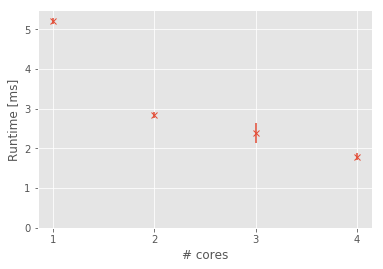

In [22]:
(timings_mean, timings_stdev) = sq_matr_mult_timings(5000, range(1, 5), plot_results=True)

As you can see, the runtime did not decrease linearly with the number of available cores but there are definitely benefits from using more than one CPU core.

Let's try that again but this time with a smaller problem size.

7.34 µs ± 56.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.47 µs ± 152 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.86 µs ± 85.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.44 µs ± 13.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


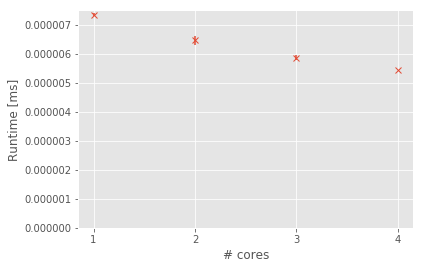

In [23]:
(timings_mean, timings_stdev) = sq_matr_mult_timings(50, range(1, 5), plot_results=True)

Here the scaling with CPU cores is much poorer.

You'd like to hope that as you distribute work between more threads that there will be a linear decrease in execution time.  However, that's not always the case:

 - If there are more threads than cores then threads will have to take it in turns to run;
 - For a given matrix size: as the number of threads grows at some point the cost of setup, tear-down and inter-thread communication/synchronisation may become significant.  This is what is happening with the smaller problem size above.  As we increase the problem size above that of the first example we  than the first example then we should asymptotically converge on linear scaling.
 - It is useful to consider [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law) when assessing how well a problem will scale with more parallelisation: this law broadly states that speedup of parallelising some code is a limited by the proportion that runs in series.  Assessing just how much code runs in series is difficult in this particular case as some code is in this Notebook, some is in the numpy package and some is in the MKL. In other situations it may be much easier for you to identify the sections of code that do (must?) execute in series and therefore limit the maximum speedup achievable by parallelisation:
 
<img src="static/parallel_code_with_serial_sections.svg" alt="Parallel code with serial sections" height="300px"
    width="200px" />

**DESCRIBE THE ABOVE**

## How many cores do we need? 

This isn't an easy question to answer and depends on the problem size and on the algorithm and code used to solve the problem.  On 'single-tenant' machines such as your own laptop it is therefore often best to just let the MKL decide on an appropriate number of threads.  This is what it does by default; we've only explicitly set the thread count here to demonstrate the effects of multithreading on performance.

On 'multi-tenant' systems such as HPC clusters like ShARC one typically needs to request the number of cores required at the start of the job then within the job there may be hundreds or possibly millions of multi-threadable linear algebra operations (or other multi-threadable operations if using something other than the MKL behind the scenes).   How many cores should one request of the Distributed Resource Manager that controls the cluster when you first submit/start your job?  Well, if you think you might benefit from multithreading and are using a library that supports it then try running some short tests with what you believe are the worst-case problem sizes within your job and, as above, capturing execution times for different thread/core counts to see how your problem scales with CPU cores.    

## A note on physical vs virtual processing cores (hyperthreading)

 Be aware that on the majority of modern Intel processors that each physical CPU core typically provides two *virtual cores* aka *hardware threads* using a technology called [Hyper-Threading](https://en.wikipedia.org/wiki/Hyper-threading). 
 
 
These virtual cores provide greater parallelism for workloads that are primarily IO (input/output) such as networking, running databases or interactive desktop/laptop usage.  However, you do not want to distribute floating-point calculations between both virtual cores of a physical core as the virtual cores share part of the physical core that handles floating-point calculations (the Floating Point Unit (FPU)).  Contention between virtual cores for the FPU can result in numerical workloads running slower with than if hyperthreading were disabled.  For this reason hyperthreading is disabled on all nodes in ShARC (bar a small number dedicated for CPU usage.  

You can check to see if hyperthreading is enabled using a program called `lstopo`, which shows the internal architecture of a machine.  Here's graphical output from lstopo for a Dell XPS 9550 laptop.  This shows that each of the four physical cores is comprised of two virtual cores i.e. hyperthreading is enabled. 
 
<img src="static/dell-xps-9550-lstopo-cpu-ram.svg" alt="Parallel code with serial sections" width="30%"/>
 
Here's graphical output from lstopo for one of the (16-core) nodes in ShARC where hyperthreading is disabled.  
 
<img src="static/sharc-node005-lstopo-cpu-ram.svg" alt="Parallel code with serial sections" width="60%"/>

Run the following cell to see the architecture of the machine running this Jupyter Notebook.  

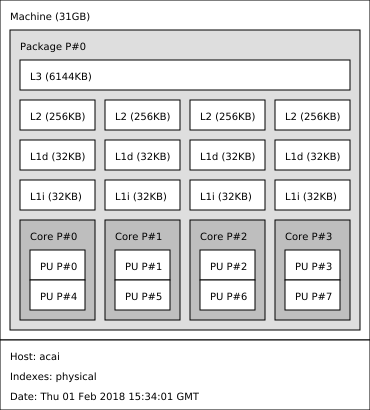

In [35]:
tmp = os.path.join(os.sep, 
                   os.environ['TMPDIR'] if 'TMPDIR' in os.environ else 'tmp',
                   str(os.getpid()))
!lstopo --no-io --no-bridges --output-format svg -f {tmp}
with open(tmp, 'r') as svg_file:
    svg = svg_file.read()
SVG(svg)

---
OTHER LIBRARIES CAN USE MKL TOO, EITHER BY DEPENDING ON NUMPY OR BY USING MKL DIRECTLY E.G. SCIPY

Other Python packages can use the MKL for linear algebra, either by depending on Numpy or by using the MKL directly.  

The scipy package, for example, can accelerate more involved operations such as **singular value decomposition** (**TODO**: LINK) using the MKL

In [13]:
z = np.random.random_sample((1000, 80))

thread_cnts = np.arange(1, 5)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -n 5 -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

22.3 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
17.2 ms ± 879 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
15.5 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
13.8 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


BEST TO USE UP TO AS MANY THREADS AS AVAILABLE CPU CORES: USE MORE THAN THAT AND SOME THREADS WILL BE FORCED TO SPEND SOME TIME WAITING, WHICH IS INEFFICIENT USE OF CORES

In [14]:
z = np.random.random_sample((1000, 80))

thread_cnts = np.arange(1, 16, 4)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -n1 -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

23.6 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.9 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.6 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.7 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


WHY NOT USE ALWAYS USE AS MANY THREADS AS AVAILABLE CORES?  SOMETIMES MAY WANT TO LIMIT MKL THREADS SO CAN HAVE MULTIPLE PROCESSES RUNNING AT ONCE THAT DON'T INTERFERE WITH EACH OTHER. (DIAG)

## Accelerating FFTs using pyfftw and multiple threads

As we've seen, numpy can use the Intel MKL for multi-threaded linear algebra operations.  The MKL also includes [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (FFT) functions that can also use multiple threads and therefore multiple cores for distributing work.  However, although the numpy FFT functions can use the MKL for FFT calculations the MKL is not called in a way that allows multiple threads to be used efficiently.

Let's use this an opportunity to explore how a different Python package, [pyfftw](https://hgomersall.github.io/pyFFTW/), uses a different compiled library, [FFTW](http://fftw.org), to provide efficient multithreaded FFT functions.  FFTW is a very widely used and mature FFT library that can calculate 1D, 2D and 3D forward and inverse FFTs. 

Note: here we use pyfftw's native and most efficient way of calculating FFTs, which involves preallocating input and output arrays then generating then evaluating a execution plan.  If you want a more concise way of using pyfftw that presents an interface that very closely mirrors the FFT-related parts of the numpy API then see `pyfftw.interfaces.numpy_fft.fft` and/or `pyfftw.builders.fft`.

In [4]:
# Size of 3D FFT input
size = (1024, 1024, 128)

# Preallocate a 2GB array of complex values for storing randomly generated input data.
# This preallocation allows the array to be 'aligned' in memory in a way that offers 
# best performance on hardware with SIMD support (e.g. with AVX support; see mention of SIMD in the next section)
a = pyfftw.empty_aligned(size, dtype='complex128')
out = pyfftw.empty_aligned(size, dtype='complex128')

# Randomly generate the real and imaginary components of our 3D FFT input
a[:] = np.random.randn(*size) + (1j * np.random.randn(*size))

3.27 s ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.05 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.52 s ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.43 s ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


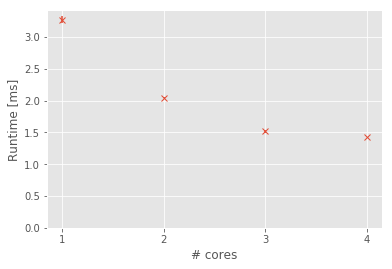

In [5]:
# To store timings for the FFT calculations
timings_mean = []
timings_stdev = []

# Range of thread counts for which to measure performance
thread_cnts = np.arange(1, 5)

for i in thread_cnts:
    # Constructs a plan for how to calculate the FFT efficiently given the input data type and size 
    # Note that we're not timing this setup function
    fft_plan = pyfftw.FFTW(a, out, threads=i) 
    
    # Time the FFT calculation
    timings = %timeit -o fft_plan.execute()

    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)
    
# Plot the results
fig, ax = plt.subplots()
ax.errorbar(thread_cnts, timings_mean, yerr=timings_stdev, fmt='x')
ax.set_xticks(thread_cnts)
ax.set_xticklabels(thread_cnts)
ax.set_xlabel('# cores')
ax.set_ylabel('Runtime [ms]');
ax.set_ylim(ymin=0);

# Free memory
del a, out

Note that for this 3D 2GiB matrix of complex values the forward FFT scaling doesn't improve much beyond a couple of cores.

**TODO**: WHY IS THIS?  If you re-run the above two cells after setting `size` in the first cell so that 

```
size = (1024 * 1024 * 128, )
```

so as to use 1D inputs and outputs then there's a bit better scaling as you move from 2 to 3 cores.

## Using the MKL on CPUs that can accelerate certain operations 

Another easy win when it comes to performance is making sure that you use the MKL on CPU(s) that have:

* Support for atomically applying the same operation to vectors of values ('Single Instruction Multiple Data' (SIMD) hardware vectorisation) using some flavour of Intel's [Advanced Vector Extensions][avx] (AVX). 
* Support for atomically multiplying two values and adding them to an 'accumulator' CPU [register][cpu-reg] (storage location on the CPU).  This CPU instruction, known as [fused multiply-add][fma] (FMA), can help speed up matrix multiplication as that operation consists entirely of sums of multiplications.  

You can get additional performance out of many libraries, not just the MKL, if they are able to use AVX and/or FMA.  With AVX this typically requires that software is written and compiled so that it is AVX-aware but the MKL is able to just detect and use AVX and FMA at execution time, making life much easier for the numpy user.  

The CPUs in the ShARC cluster at the University of Sheffield have both AVX2 and FMA support. You can check if you have AVX and/or FMA support using the [cpuinfo][cpuinfo] Python package:

[avx]: https://en.wikipedia.org/wiki/Advanced_Vector_Extensions
[cpu-reg]: https://en.wikipedia.org/wiki/Processor_register
[fma]: https://en.wikipedia.org/wiki/Multiply%E2%80%93accumulate_operation#Fused_multiply%E2%80%93add
[cpuinfo]: https://github.com/workhorsy/py-cpuinfo

In [6]:
cpu_features = cpuinfo.get_cpu_info()['flags']
set(cpu_features).intersection(set(('fma', 'avx', 'avx2', 'avx512')))

{'avx', 'avx2', 'fma'}

or from the command-line:

In [7]:
!grep -oE '\W(fma|avx|avx2)\W' /proc/cpuinfo | sort | uniq

 avx 
 avx2 
 fma 


*Jupyter Tip: if a line in a code cell starts with `!` then the rest of the line is run in a shell, not executed as Python code.*

# MOVE ELSEWHERE

**TODO**: Useful for looking at effect of oversubscription and for parameterising thread ranges?  Only if output is limited by cgroups/cpusets - NO! TODO: check on ShARC.  Todo: explain hardware threads, hyperthreading, physical cores per socket, sockets, numactl

In [21]:
def get_phys_cores():
    hardware_threads = cpuinfo.get_cpu_info()['count'] 
    if 'ht' in cpuinfo.get_cpu_info()['flags']:
        cores = int(hardware_threads / 2)
    else:
        cores = hardware_threads
    return cores

phys_cores = get_phys_cores()
phys_cores

(8, 4)

In [18]:
%%bash 
hardware_threads=$(grep -Ec '^processor\W' /proc/cpuinfo)
if grep -Eq '^flags.*\Wht\W' /proc/cpuinfo; then
    phys_cores=$((hardware_threads / 2))
else
    phys_cores=$hardware_threads
fi
echo $hardware_threads, $phys_cores

8, 4


In [25]:
%%bash
# Shows all hardware threads, not physical cores
taskset -pac $$

pid 12995's current affinity list: 0-7


In [26]:
%%bash
# Show just physical cores (restricted by cgroup!)
lstopo --only cores

Core L#0
Core L#1
Core L#2
Core L#3


In [27]:
%%bash
# Show hardware threads (restricted by cgroup!)
lstopo --only pu

PU L#0 (P#0)
PU L#1 (P#4)
PU L#2 (P#1)
PU L#3 (P#5)
PU L#4 (P#2)
PU L#5 (P#6)
PU L#6 (P#3)
PU L#7 (P#7)
